# <font color='black'> НИС: регрессионный анализ, 2025 </font>
## <font color='black'> Модели бинарного выбора </font>
В рамках данного практического занятия мы потренируемся в оценивании и интерпретации оценок моделей бинарного выбора. По мотивам статьи [Joan Esteban, Laura Mayoral, Debraj Ray "Ethnicity and Conflict: an Empirical Study"
American Economic Review 2012, 102(4): 1310–1342] рассмотрим зависимость степени конфликта от таких мер, как поляризация и фракционализация. Ниже представлено краткое описание данных:

* prioInt - «Conflict intensity» from PRIO: we assign a value of 0 if there is peace in a given year, a value of 1 if there is a weak conflict in a given year,
and a value of 2 if there is a strong conflict in a given year
* prioIntLag - Lagged conflict intensity
* f - Fractionalization index (data from Fearon (2003b) and the
Ethnologue project)
* p - Polarization index (Group shares are constructed
as above, for f; data on language and linguistic distances come from
Ethnologue)
* gini - Greenberg-Gini index (Ethnologue; Fearon (2003)
* gpd - Log of real GDP per capita
* pop - Log of population
* mount - Percent mountainous terrain
* ncont - Noncontiguous states, referring to countries with territory holding at
least 10,000 people and separated from the land area containing the
capital city either by land or by 100 kilometers of water





In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import statsmodels.formula.api as smf
from scipy.stats import chi2
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score

Оставим в массиве только необходимые переменные для анализа. Кроме этого, перекодируем показатель степени конфликта (prioInt) в бинарный
показатель таким образом, чтобы нулю соответствовало отсутствие конфликта,
а единица объединяла бы две категории: «слабый конфликт» и «сильный конфликт». Выполним подобные преобразования применительно и к лагированному
показателю (prioIntLag)

In [2]:
lab7 = pd.read_stata('lab_logit.dta')
lab7 = lab7[['prioInt', 'prioIntLag', 'f', 'p', 'gini', 'gdp', 'pop', 'mount', 'ncont']].dropna()

In [3]:
lab7['prioInt_labels'] = lab7['prioInt'].map({0: 'No conflict', 1: 'Weak conflict', 2: 'Strong conflict'})

[Text(0, 0, '72.89'), Text(0, 0, '16.62'), Text(0, 0, '10.49')]

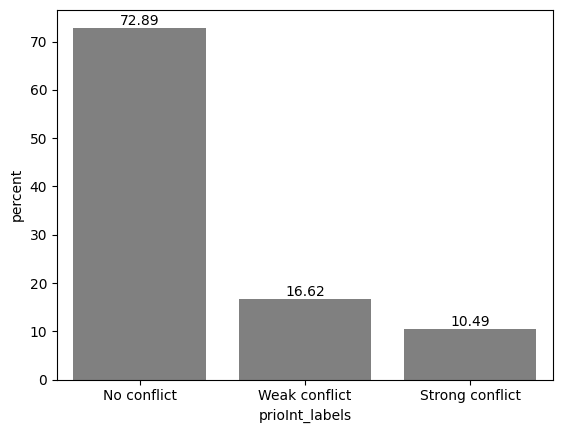

In [4]:
distr = sns.countplot(x=lab7['prioInt_labels'], color = 'grey', stat = 'percent', order = lab7['prioInt_labels'].value_counts().index)
percent = lab7['prioInt_labels'].value_counts(ascending=False, normalize=True).values * 100
distr.bar_label(container=distr.containers[0], labels=np.round(percent,2))

In [5]:
lab7['prioInt_binary'] = lab7['prioInt'].apply(lambda x: 1 if x > 0 else 0)
lab7['prioIntLag_binary'] = lab7['prioIntLag'].apply(lambda x: 1 if x > 0 else 0)

Оценим логит-модель с prioInt_binary в качестве зависимой переменной

In [6]:
m1_logit = smf.logit("prioInt_binary ~ prioIntLag_binary + f + p + gini + gdp + pop + mount + ncont", data=lab7).fit(cov_type = "HC3")
print(m1_logit.summary())

Optimization terminated successfully.
         Current function value: 0.358957
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         prioInt_binary   No. Observations:                 1125
Model:                          Logit   Df Residuals:                     1116
Method:                           MLE   Df Model:                            8
Date:                Mon, 24 Nov 2025   Pseudo R-squ.:                  0.3857
Time:                        22:22:34   Log-Likelihood:                -403.83
converged:                       True   LL-Null:                       -657.41
Covariance Type:                  HC3   LLR p-value:                2.047e-104
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.5296      1.589     -0.962      0.336      -4.645       1.586
prioIntL

Сравним полученные оценки с соответствующими оценками probit-модели (данная модель основывается на допущении о стандартном нормальном распределении ошибок)

In [7]:
m1_probit = smf.probit("prioInt_binary ~ prioIntLag_binary + f + p + gini + gdp + pop + mount + ncont", data=lab7).fit(cov_type = "HC3")
print(m1_probit.summary())

Optimization terminated successfully.
         Current function value: 0.358154
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:         prioInt_binary   No. Observations:                 1125
Model:                         Probit   Df Residuals:                     1116
Method:                           MLE   Df Model:                            8
Date:                Mon, 24 Nov 2025   Pseudo R-squ.:                  0.3871
Time:                        22:22:34   Log-Likelihood:                -402.92
converged:                       True   LL-Null:                       -657.41
Covariance Type:                  HC3   LLR p-value:                8.384e-105
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.7721      0.857     -0.901      0.368      -2.452       0.908
prioIntL

In [8]:
logit_probit_ratios = pd.DataFrame(
    {"logit": round(m1_logit.params, 3),
     "probit": round(m1_probit.params, 3),
     "logit/probit": round(m1_logit.params/m1_probit.params, 3)}
    )

print(logit_probit_ratios)

                   logit  probit  logit/probit
Intercept         -1.530  -0.772         1.981
prioIntLag_binary  2.735   1.616         1.692
f                  1.322   0.738         1.791
p                  7.366   4.054         1.817
gini              -4.743  -2.650         1.790
gdp               -0.472  -0.270         1.748
pop                0.132   0.069         1.907
mount              0.006   0.003         1.715
ncont              0.849   0.468         1.814


Преобразуем оценки логит-модели в отношения шансов:

In [9]:
odds_ratios = pd.DataFrame(
    {"OR": round(np.exp(m1_logit.params), 3),
     "p-value": round(m1_logit.pvalues, 3),
     "Lower CI": round(np.exp(m1_logit.conf_int()[0]),3),
     "Upper CI": round(np.exp(m1_logit.conf_int()[1]),3)}
    )

print(odds_ratios)

                         OR  p-value  Lower CI   Upper CI
Intercept             0.217    0.336     0.010      4.882
prioIntLag_binary    15.404    0.000    10.681     22.217
f                     3.751    0.002     1.611      8.736
p                  1581.254    0.000    31.004  80645.550
gini                  0.009    0.135     0.000      4.368
gdp                   0.624    0.000     0.513      0.759
pop                   1.141    0.100     0.975      1.335
mount                 1.006    0.199     0.997      1.015
ncont                 2.337    0.002     1.383      3.949


Также возможен вариант интерпретации оценок коэффициентов при непрерывных переменных через предельные эффекты:

In [10]:
ME = m1_logit.get_margeff()
print(ME.summary())

        Logit Marginal Effects       
Dep. Variable:         prioInt_binary
Method:                          dydx
At:                           overall
                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
prioIntLag_binary     0.2967      0.012     25.443      0.000       0.274       0.320
f                     0.1434      0.047      3.059      0.002       0.052       0.235
p                     0.7992      0.214      3.730      0.000       0.379       1.219
gini                 -0.5146      0.344     -1.495      0.135      -1.190       0.160
gdp                  -0.0512      0.011     -4.660      0.000      -0.073      -0.030
pop                   0.0143      0.009      1.655      0.098      -0.003       0.031
mount                 0.0006      0.000      1.283      0.200      -0.000       0.002
ncont                 0.0921      0.029      3.192      0.001       0.036 

В качестве предварительной диагностики модели можно использовать тест Хосмера-Лемешева (Hosmer-Lemeshow). Посредством данного теста мы сравним ожидаемые и наблюдаемые частоты по подгруппам (чаще всего берется разделение по децилям). Надо признать, что результаты теста довольно чувствительны к количеству групп, на которые делится массив данных.

In [11]:
X = lab7[['prioIntLag_binary', 'f', 'p', 'gini', 'gdp', 'pop', 'mount', 'ncont']]
y = lab7[['prioInt_binary']]

In [12]:
y_prob = m1_logit.predict(X)
y_prob1 = pd.concat([y_prob, y], axis = 1)
y_prob1['decile'] = pd.qcut(y_prob1[0], 10)

In [13]:
obsevents_pos = y_prob1['prioInt_binary'].groupby(y_prob1.decile, observed = True).sum()
obsevents_neg = y_prob1[0].groupby(y_prob1.decile, observed = True).count() - obsevents_pos
expevents_pos = y_prob1[0].groupby(y_prob1.decile, observed = True).sum()
expevents_neg = y_prob1[0].groupby(y_prob1.decile, observed = True).count() - expevents_pos
decile_dataset = pd.concat([obsevents_pos, obsevents_neg, expevents_pos, expevents_neg], axis = 1)
decile_dataset.columns=['obs_pos','obs_neg','exp_pos', 'exp_neg']
print(decile_dataset)

                      obs_pos  obs_neg    exp_pos     exp_neg
decile                                                       
(-0.0009117, 0.0366]        1      112   2.899912  110.100088
(0.0366, 0.0475]            4      108   4.643774  107.356226
(0.0475, 0.0636]            7      106   6.252347  106.747653
(0.0636, 0.0846]           10      102   8.152377  103.847623
(0.0846, 0.113]            10      103  11.182455  101.817545
(0.113, 0.172]             21       91  15.757412   96.242588
(0.172, 0.251]             19       93  23.411940   88.588060
(0.251, 0.662]             51       62  50.371134   62.628866
(0.662, 0.815]             82       30  84.135841   27.864159
(0.815, 0.947]            100       13  98.192807   14.807193


In [14]:
hl = ((obsevents_neg - expevents_neg)**2/expevents_neg).sum()+((obsevents_pos - expevents_pos)**2/expevents_pos).sum()
df = 8
pvalue=1-chi2.cdf(hl,df)
print('chi-square: {:.2f}'.format(hl))
print('p-value: {:.2f}'.format(pvalue))

chi-square: 5.62
p-value: 0.69


Для лучшего понимания, насколько хорошо модель предсказывает наличие и отсутствие конфликта, представим confusion matrix:

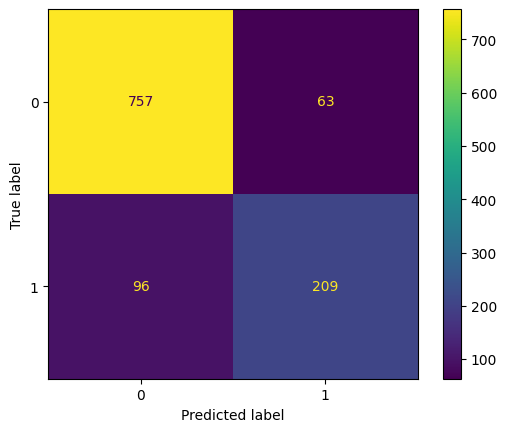

In [15]:
y_pred = y_prob1[0].apply(lambda x: 1 if x > 0.5 else 0)
confmatrix = confusion_matrix(y_true=lab7['prioInt_binary'], y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confmatrix)
disp.plot()

In [16]:
TP = confmatrix[1][1]
TN = confmatrix[0][0]
FP = confmatrix[0][1]
FN = confmatrix[1][0]

Accuracy = round((TP + TN) / (TP + TN + FP + FN), 3)
Baseline_Accuracy = round(max((TN + FP), (FN + TP)) / (TP + TN + FP + FN) , 3)

Sensitivity = round(TP / (TP + FN), 3)
Specificity = round(TN / (TN + FP), 3)
ErrorI = round((1 - Specificity), 3)
ErrorII = round((1-Sensitivity), 3)

print('Accuracy: {:.2f}'.format(Accuracy)),
print('Baseline_Accuracy: {:.2f}'.format(Baseline_Accuracy))
print('Sensitivity: {:.2f}'.format(Sensitivity))
print('Specificity: {:.2f}'.format(Specificity))
print('ErrorI: {:.2f}'.format(ErrorI))
print('ErrorII: {:.2f}'.format(ErrorII))

Accuracy: 0.86
Baseline_Accuracy: 0.73
Sensitivity: 0.69
Specificity: 0.92
ErrorI: 0.08
ErrorII: 0.32


Проследим, как изменяются меры чувствительности и ошибки первого рода в зависимости от выбранного порогового значения:

In [17]:
fpr, tpr, thresholds = roc_curve(y, y_prob)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.3f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [18]:
df = pd.DataFrame({
    'Specificity': 1-fpr,
    'Sensitivity': tpr
}, index=thresholds)
df.index.name = "Thresholds"
df.columns.name = "Rate"

fig_thresh = px.line(
    df, title='Sensitivity and Specificity at different thresholds',
    width=700, height=500
)

fig_thresh.update_yaxes(scaleanchor="x", scaleratio=0.75)
fig_thresh.update_xaxes(range=[0, 1], constrain='domain')
fig_thresh.show()

Определим порог, при котором значения специфичности и чувствительности будут сбалансированы:

In [19]:
diff = np.abs(tpr-(1-fpr))
min_diff = np.argmin(diff)

optimized_threshold = thresholds[min_diff]

optimized_threshold

np.float64(0.19870652405623176)

Переоцените модель при заданном пороговом значении (optimized_threshold) и прокомментируйте, как изменились меры качества модели